In [1]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\junka\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

The goal is to do a sentiment analysis on the reviews from Tripadvisor regrading Univeral Studios Singapore (USS), identify what guests liked and identify pain points to be potentially tackled.



### Data Cleaning:

First, we read the file and dropped some less useful columns. The columns dropped are Review Id, Display Name, User Name, User Profile, User Avatar, User Is Verified, Additional Ratings, Photos, Location Id, URL, Created Date, Published Date and Location.

In [2]:
df = pd.read_csv("tripadvisor_20250213222526.csv")
df = df.drop(columns=['Review Id', 'Display Name', 'User Name', 'User Profile',
                      'User Avatar', 'User Is Verified','Additional Ratings', 'Photos',
                       'Location Id', 'URL', 'Created Date', 'Published Date', 'Location'])

We are then left with the below attributes.

In [3]:
print(df.columns)

Index(['User ID', 'User Location', 'Rating', 'Review Title', 'Review Text',
       'Helpful Votes', 'Stay Date', 'Language'],
      dtype='object')


We observed that there are reviews not in english. 

In [4]:
print(df["Language"].unique())

['en' 'zhCN' 'es' 'ru' 'pl' 'fr' 'sv' 'ja' 'ko' 'da' 'in' 'it' 'nl' 'th'
 'de' 'ar' 'pt' 'el' 'zhTW' 'tr' 'no' 'vi' 'fi' 'iw' 'sk' 'hu' 'sr' 'cs']


While there are existing packages that could translate these reviews to English, we have no means of verifying whether the translations would be accurate, and since we're doing sentiment analysis, where the choice of words would determine the emotional tone and attitudes expressed, we opted to remove non-English reviews.

After removing non-English reviews, there are 7076 rows left

In [5]:
df = df[df['Language'] == 'en']
#drop Language col after filtering for only english reviews
df = df.drop(columns = ['Language'])


print(df.columns)  #Displayes the columns in the df
print(df.shape[0])  # Displays the number of rows


Index(['User ID', 'User Location', 'Rating', 'Review Title', 'Review Text',
       'Helpful Votes', 'Stay Date'],
      dtype='object')
7076


We observed that there are 2 Locations 'Universal Studios Singapore' and 'Universal Studios Singapore Tickets', which are used interchangeably by reviewers.

In other words, reviewers who wrote down the location as 'Universal Studios Singapore Tickets' are also talking about the park as a whole as opposed to just talking about the ticketing system. 

Therefore, the attribute 'Location' will be dropped as well. This is done above with the other dropped attributes for the sake of neatness.

In [6]:
''' 

print(df["Location"].unique())
count = df[df['Location'] == 'Universal Studios Singapore Tickets'].shape[0]
print(count)
count2 = df[df['Location'] == 'Universal Studios Singapore'].shape[0]
print(count2)

pd.set_option('display.max_colwidth', None)  # Set to None to show full text without truncation

filtered_reviews = df[df['Location'] == 'Universal Studios Singapore Tickets']['Review Title']
print(filtered_reviews)

'''


' \n\nprint(df["Location"].unique())\ncount = df[df[\'Location\'] == \'Universal Studios Singapore Tickets\'].shape[0]\nprint(count)\ncount2 = df[df[\'Location\'] == \'Universal Studios Singapore\'].shape[0]\nprint(count2)\n\npd.set_option(\'display.max_colwidth\', None)  # Set to None to show full text without truncation\n\nfiltered_reviews = df[df[\'Location\'] == \'Universal Studios Singapore Tickets\'][\'Review Title\']\nprint(filtered_reviews)\n\n'

The column 'User Location' has 1654 missing values, we might want to consider removing these too, especially if we're not doing a demographic by location analysis.

In [7]:
print(df.isnull().sum())  # Check for missing values in each column
# Print the data types of each column


User ID             0
User Location    1654
Rating              0
Review Title        0
Review Text         0
Helpful Votes       0
Stay Date           0
dtype: int64


Converting to the right data types


In [8]:
print(df.dtypes)

#Convert 'Stay Date' to a date type variable
df['Stay Date'] = pd.to_datetime(df['Stay Date'], errors='coerce')



User ID          object
User Location    object
Rating            int64
Review Title     object
Review Text      object
Helpful Votes     int64
Stay Date        object
dtype: object


### Data preprocessing (Text preprocessing):

The goal is to clean and standardise textual data for analysis. We applied the following techniques to the attributes Review Title and Review Text.

1. Remove special characters, numbers, and extra spaces.
    - This eliminates unnecessary noise from things like punctuation, symbols, and redundant whitespace. This helps to standardize text for ML models.

2. Convert text to lowercase.
    - Ensures consistency by eliminating case sensitivity and preventing the duplication of words due to different capitalizations. This helps match texts and reduces vocabulary size.


3. Tokenization and removing stopwords.
    - Removing stop words like "the", "is", "and", etc. that don’t add much meaning. This is to reduce text size once again.

4. Lemmatization.
    - Converts words to their base form to normalize the variations of the same word. This reduces vocabulary size and improves model generalisation. 


In [9]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    """Lowercase, remove special characters, and extra spaces."""
    text = text.lower().strip()
    text = re.sub(r'[^a-z0-9\s]', '', text) # Keep only alphanumeric characters
    text = re.sub(r'\s+', ' ', text).strip() # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words] # Remove stopwords + Lemmatization
    return ' '.join(words)

df['Clean Review Title'] = df['Review Title'].apply(clean_text)
df['Clean Review Text'] = df['Review Text'].apply(clean_text)

Finally, we can preview the dataset below

In [10]:
print(df.head())

                            User ID  User Location  Rating  \
0  2165A55827C624A5FA8BA42A63DA343C  United States       3   
1  87364D4E6E971222E18CB6C485C9209E            NaN       5   
2  DC02DAA61A0CD9DC77B4C83FC2A79A09      Edinburgh       4   
3  3E7A5D8CEA2FB93CCB415499204B9E77            NaN       1   
4  C9CC6FD8B4C7A6EC72E0088AF811CA82         Sydney       4   

                    Review Title  \
0                      It’s okay   
1  Great Staff, Great Experience   
2    Great day out, pretty small   
3                      Pointless   
4                        Fun day   

                                         Review Text  Helpful Votes  \
0  This was relatively small, ~24 rides(?), lines...              0   
1  Staff at Universal and RWS were so lovely and ...              0   
2  Great day out, with plenty of shade and seats ...              0   
3  Pointless place.\nWait times are over 60 mins ...              0   
4  Not as good as Universal in LA. \n\nHighly rec...   

### Exploratory Data Analysis

Looking at the distribution of the guests' ratings, we get a preliminary idea of how the overall experience is perceived. We can see from the bar chart that the vast majority of guests rated their experience at least a 4 out of 5. We can then expect that sentiment analysis will also reveal to be largely positive.  

C:\Users\junka\AppData\Local\Temp\ipykernel_17060\1184892035.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')


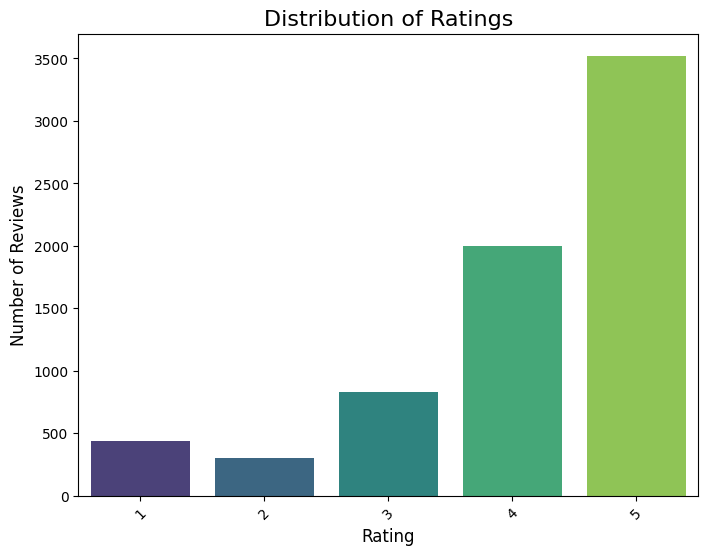

In [11]:
import matplotlib.pyplot as plt
import seaborn as sns

# Count the occurrences of each rating
rating_counts = df['Rating'].value_counts().sort_index()

# Create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(x=rating_counts.index, y=rating_counts.values, palette='viridis')

# Adding labels and title
plt.title('Distribution of Ratings', fontsize=16)
plt.xlabel('Rating', fontsize=12)
plt.ylabel('Number of Reviews', fontsize=12)
plt.xticks(rotation=45)

# Show the plot
plt.show()


## Sentiment Analysis

### VADER 
We used VADER (Valence Aware Dictionary and Sentiment Reasoner) to perform the sentiment analysis. VADER is a vocabulary and rule-based feeling analysis instrument that was designed to be sensitive towards the way people communicate in web-based media. 

Every word in the vocabulary is appraised more positive words will have a higher positive evaluation and more negative words will have a more negative score.

Using this on our dataset, the reviews would be scored between -1 to 1 and categorized into the following categories:
- positive (score > 0.05) 
- neutral (-0.05 < score < 0.05)
- negative (score < -0.05)

### Reasoning
Why do sentiment analysis when we already have a Rating column?
- To better capture emotional tone. For example, a high rating (eg 4 stars) may not mean the review is fully positive. Doing sentiment analysis will help detect nuanced opinions.
- To better handle Rating inconsistencies. Users might also perceive ratings differently from one another which makes the Rating attribute potentially inconsistent.




In [12]:
import nltk
#nltk.download('vader_lexicon')

from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


def get_sentiment(text):
    sentiment = sid.polarity_scores(text)
    return sentiment['compound']  # The compound score indicates overall sentiment

df['Sentiment'] = df['Clean Review Text'].apply(get_sentiment)
df['Sentiment_Label'] = df['Sentiment'].apply(lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))
df['Sentiment_Label'].value_counts()



Sentiment_Label
positive    6383
negative     566
neutral      127
Name: count, dtype: int64

Just as we suspected, the reviews are largely positive.
 

C:\Users\junka\AppData\Local\Temp\ipykernel_17060\3616727118.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Label', data=df, palette='viridis')


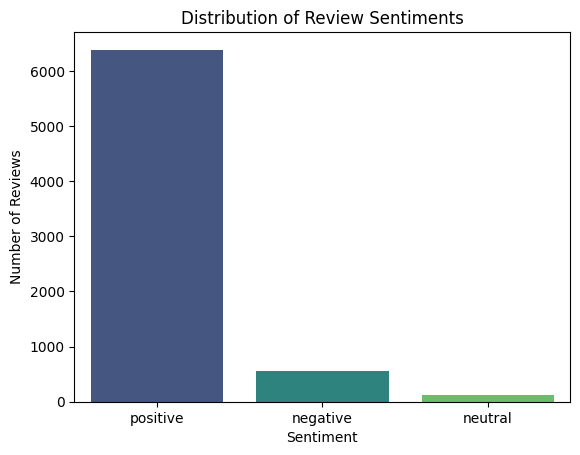

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot sentiment distribution
sns.countplot(x='Sentiment_Label', data=df, palette='viridis')
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.show()


## Bigram Anaylsis

To better identify key themes in positive and negative feedback, we analyze common word pairs (bigrams) in positive and negative reviews to identify key phrases associated with sentiment. Here we extracted the top 20 for both positive and negative reviews. This will provide insights into common praises and common complaints of USS.

### Positive reviews:

The phrase "express pass" stands out prominently, suggesting that positive experiences are closely tied to a premium experience—specifically, the ability to skip lines by purchasing the Express Pass.

Additionally, phrases like "waiting time" indicate that guests prioritize a reasonable queuing experience, implying that the efficiency of wait times plays a significant role in their overall satisfaction.

Finally, the frequent mention of specific ride names highlights that the attractions themselves are key highlights of the visit, suggesting that customers value the quality and experience of the rides.


### Negative reviews:

"Express pass" appears frequently in negative reviews, suggesting that the service did not meet customer expectations. This likely reflects situations where guests felt the Express Pass did not significantly reduce wait times as anticipated. Additionally, given the higher cost of these passes, customers may have had high expectations for the service, only to be disappointed by the actual experience. This is further corroborated by the presence of phrases like "waiting time" and "waste of money", which indicate frustration with the perceived value. This underscores the importance of the queuing experience in determining overall customer satisfaction.

In [14]:

from sklearn.feature_extraction.text import CountVectorizer

# Create bigrams (or trigrams)
vectorizer = CountVectorizer(ngram_range=(2, 2))  # (2, 2) for bigrams, change to (3, 3) for trigrams
positive_reviews = df[df['Sentiment_Label'] == 'positive']['Clean Review Text']
negative_reviews = df[df['Sentiment_Label'] == 'negative']['Clean Review Text']

# Create the term-document matrix for positive and negative reviews
positive_ngrams = vectorizer.fit_transform(positive_reviews)
negative_ngrams = vectorizer.transform(negative_reviews)

# Get the sum of each bigram
positive_ngrams_sum = positive_ngrams.sum(axis=0).A1
negative_ngrams_sum = negative_ngrams.sum(axis=0).A1

# Get the feature names (bigrams)
positive_ngrams_words = vectorizer.get_feature_names_out()
negative_ngrams_words = vectorizer.get_feature_names_out()

# Create DataFrames to view the bigrams and their counts
positive_bigrams = pd.DataFrame(list(zip(positive_ngrams_words, positive_ngrams_sum)), columns=["Bigram", "Count"])
negative_bigrams = pd.DataFrame(list(zip(negative_ngrams_words, negative_ngrams_sum)), columns=["Bigram", "Count"])

# Sort by frequency
positive_bigrams = positive_bigrams.sort_values(by="Count", ascending=False).head(20)
negative_bigrams = negative_bigrams.sort_values(by="Count", ascending=False).head(20)

print("Top 20 Positive Bigrams:")
print(positive_bigrams)

print("\nTop 20 Negative Bigrams:")
print(negative_bigrams)


Top 20 Positive Bigrams:
                      Bigram  Count
142357      universal studio   2244
46735            express pas   1450
113076        roller coaster   1044
133031            theme park    967
139445      transformer ride    745
69054          jurassic park    732
147012          waiting time    611
146635             wait time    491
129246      studio singapore    462
46800         express ticket    429
75824             long queue    423
85540             mummy ride    366
16008   battlestar galactica    358
58885              great day    327
151535             whole day    321
154475              year old    316
48638               fast pas    310
20664            buy express    300
85944             must visit    291
110137         revenge mummy    286

Top 20 Negative Bigrams:
                  Bigram  Count
142357  universal studio    161
46735        express pas    135
147012      waiting time     77
133031        theme park     77
146635         wait time     69
4